<em>Re-submission Note</em>: I originally submitted an RNN post but realized I made some major mistakes (I'm learning as I go). This is almost a complete re-do. One of the issues was that the RNN was not training properly, and I have not been able to get it to reliably train with my own implementation of gradient descent, so here I will calculate the gradients and hand those off to a scipy optimizer to find the weights.

###Assumptions:

I'm assuming you already know how to build a simple neural network (e.g. to solve XOR) and train it using backpropagation. I have a previous post covering backpropagation/gradient descent and at the end of that tutorial I build and train a neural network to solve the XOR problem, so I recommend making sure you understand that because I am basing the RNNs I demonstrate here off of that. I also assume you have a functional understanding of Python/numpy.

###Summary & Motivations:

This blog is my journey into learning the fundamentals of machine learning and other quantitative principles and applications and is generally in chronological order of my learning. After I successfully learned how to make feedforward neural networks and train them, I really wanted to learn how to make recurrent neural networks (RNNs). I understood that they were for temporal/sequential data and thus they could learn relationships through time. But I could not for the life of me figure out how to make the jump from a feedforward neural net to an RNN until I watched this youtube video: https://www.youtube.com/watch?v=e2sGq_vI41s (which I highly suggest you watch) by Jeff Heaton. Then I understood that RNNs can be implemented almost exactly like an ordinary feedforward neural network. I will re-explain some of the contents of that video here as I build a simple recurrent (Elman) neural network to solve a temporal version of the XOR problem (my favorite toy problem). I will also show you how to do basic time series/sequence prediction with a mini-mini-char-RNN implementation.

####Converting to Sequential Data: XOR

We're going to build a simple recurrent neural network to solve a sequential/temporal version of the XOR problem.
<br />Just as a reminder, here is the truth table for XOR.
<table>
<tr><td>$x_1$</td><td>$x_2$</td><td>$y$</td></tr>
<tr><td>$0$</td><td>$0$</td><td>$0$</td></tr>
<tr><td>$0$</td><td>$1$</td><td>$1$</td></tr>
<tr><td>$1$</td><td>$0$</td><td>$1$</td></tr>
<tr><td>$1$</td><td>$1$</td><td>$0$</td></tr>
</table>
<p>
So normally, in a feedforward neural network, we would feed each training example as a tuple $(x_1, x_2)$ and we would expect an output $h(x)$ that closely matches $y$ if the network has been trained. As review, here's what our ordinary feedforward XOR architecture looks like:

<img src="../images/XORnormal.png" />

In an RNN, we're going to add in the time dimension. But how? Well we simply reformat our training data to be in a time-dependent sequence.</p>
<p>Here's our new (temporal) training data:</p>
<table style="width:150px;">
<tr><td>$x$</td><td>$y$</td><td>$t$</td></tr>
<tr><td>$0$</td><td>?</td><td>$0$</td></tr>
<tr><td>$0$</td><td>0</td><td>$1$</td></tr>
<tr><td>$1$</td><td>1</td><td>$2$</td></tr>
<tr><td>$1$</td><td>0</td><td>$3$</td></tr>
<tr><td>$0$</td><td>1</td><td>$4$</td></tr>
<tr><td>$...x_n$</td><td>$...y_n$</td><td>$...t_n$</td></tr>
</table>

Where $x ... x_n$ represents our training data, $y...y_n$ are the corresponding expected values, and $t ... t_n $ represents our time steps. I arranged a sequence of bits [0 0 1 1 0] such that we can XOR the current bit and the previous bit to get the result. For every-time step our RNN is going to make output the XOR of the previous 2 bits, so notice that after the first bit $y=?$ because there is no previous bit to XOR, so we just ignore what the RNN outputs. But for $x=0, t=1$ we see that $y=0$ because XOR(0,0)=0.  Also notice how $time$ is in discrete, integer, steps. Some algorithms may actually have continous time implementation and that's something I'll likely explore in a future post. Let's take another look at our sequential data written horizontally as numpy code:

In [54]:
X = np.matrix('[0;0;1;1;0]')
Y = np.matrix('[0;0;1;0;1]') #first bit should be ignored, just arbitrarily putting 0

<p>
So what do we do with our sequential XOR data and what does our neural network look like? Well, we're simply going to feed each (one at a time) $x$ value into our neural network and expect one output value at a time. Instead of having 2 input units (excluding bias), we only need one now:
<img src="../images/XORrnn.png" />
</p>

<p>What's that loop and $t-1$ thing? Well it means we're going to take our output from the hidden layer at time $t_n$ and feed it back into our hidden layer as additional input at $t_{n+1}$ (the next time step), or we could rephrase that to say that our hidden layer input at $t_n$ includes the output of the hidden layer from $t_{n-1}$ (the previous time step).
</p>
<p>
You might be wondering how this is any more useful than an ordinary feedforward NN, and the answer is it's not really. For a problem like XOR, I can't think of a reason why you'd ever want to use an RNN over a feedforward. We're just using it here because it's familiar and I'm a reductionist. But after we get this down, we'll move onto something where RNNs really shine: sequence prediction (in our case, predicting the next character in a sequence).
</p>

###The Elman Neural Network

<p>An Elman network is in the class of "simple recurrent neural networks" (presumably because they really are simple, with no frills) and it's the type of RNN we're going to build to solve our temporal XOR problem. Here's what it looks like when applied to our XOR problem:</p>
<img src="../images/XORrnnFull.png" />

<p>where $\theta_1$ refers to the weights between the input layer and the hidden layer (a 6x4 matrix) and $\theta_2$ refers to our weights in between the hidden layer and our output layer (a 5x1 matrix).</p>
<p>
Okay so everything should make sense here except those 4 units labeled $C_1 - C_4$. Those are called <em>context</em> units in the parlance of simple RNNs. These context units are additional input units that feed the output from $t_{n-1}$'s hidden layer back into $t_n$'s hidden layer. They're treated exactly like a normal input unit, with adjustable weights. (At $t = 0$ there is no history to remember, so we have to initialize our network's context units with something, generally 0s.) Notice that we have the <b>same number of context units as we do hidden units</b>, that's by design and is simply the architecture of an Elman network.
</p>
<p>
So what we've done here by adding context units that feed the previous time step's state into the current time step is to turn that diagram with the t-1 loop into essentially an ordinary feedforward neural network. And since it's a feedforward neural network, we can train it exactly like we do with a feed forward XOR neural network: backpropagation (it often get's called <em>backpropagation through time</em> but it's just a different name for the same thing).</p>
<p>
Let's walk through the flow of how this works in the feedforward direction for 2 time steps.
<ul>
<li>1. $t=0$. Start with $x_1 = 0$ (first element in our list), intialize $C_1 - C_4$ to input 0s.</li>
<li>2. Feed those inputs (from bottom to top, $x_1, c_4, c_3, c_2, c_1, B_1$): [0,0,0,0,0,1] into the hidden layer (of course we multiply by $\theta_1$).</li>
<li>3. The hidden layer outputs $a_4, a_3, a_2, a_1, B_2$. We'll then store these values (except bias, $B_2$) in another temporary vector for the next time step. </li>
<li>4. Then our output unit uses the hidden layer outputs to produce the final output, $g(x)$</li>
<li>5. $t=1$ (next time step). So still $x_1 = 0$ (second element in our list), intialize $C_1 - C_4$ to the stored outputs of $H_1 - H_4$ from the last time we ran the network forward.</li>
<li>6. Feed those inputs (from bottom to top, $x_1, c_4, c_3, c_2, c_1, B_1$): [0, $H_4^{t-1}, H_3^{t-1}, H_2^{t-1}, H_1^{t-1}$, 1] into the hidden layer.</li>
<li>7. The hidden layer outputs $a_4, a_3, a_2, a_1, B_2$. We'll then store these values in the temporary vector for the next time step.</li>
<li>8. Then our output unit uses the hidden layer outputs to produce the final output, $g(x)$</li>
</ul>
</p>
<p>
<b>Important Notes:</b> As mentioned before, we treat the context units just like ordinary input units, that means they have weighted connections between them and the hidden layer, but their input does not go through any activation function nor do we manipulate those values in anyway before we feed them back in the next time step.
</p>

###Let's build it (updated)

<p>So as mentioned before, when I originally posted this article I attemped to train it using ordinary backpropagation/gradient descent (with momentum), and it was not reliably working. So rather than posting some code that may or may not work for you, I'm going to use scipy's optimize functions to help out the training (and even then it has issues converging sometimes). RNNs are infamously difficult to train compared to NNs. (We'll graph the cost function to see why later.) </p>

<p>
If you have taken Andrew Ng's machine learning course, then you should be familiar with Matlab's 'fminunc' (and `fmincg`) optimizer. We're going to use scipy's version, `fmin_tnc` (I'll explain how it works later). Let me just walk through the major points of the following implementation
<ul>
<li>I have a cost function defined in a separate file which accepts an 'unrolled' theta vector, so in the cost function we have to assign theta1 and theta2 by slicing the long thetaVec. This cost function returns the cost ('J') and the gradient (an unrolled vector containing theta1_grad and theta2_grad).</li>
<li> In the main code to follow, we give scipy's `fmin_tnc` our cost function and some initial weights and it quickly finds an optimal set of weights. `fmin_tnc` will return the optimal weights as an unrolled vector.</li>
<li>After we define theta1 and theta2 from the optimal weights returned, we run the network forward on a different sequence of bits to see if it really learned how to XOR the sequence one step at a time.</li>
</ul>
</p>

In [170]:
import numpy as np
from sigmoid import sigmoid
from scipy import optimize
import cost_xorRNN as cr #I defined the cost function in a separate file
X = np.matrix('[0;0;1;1;0]') #training data
Y = np.matrix('[0;0;1;0;1]') #expect y values for every pair in the sequence of X
numIn, numHid, numOut = 1, 4, 1
#initial, randomized weights:
theta1 = np.matrix( 0.5 * np.sqrt ( 6 / ( numIn + numHid) ) * np.random.randn( numIn + numHid + 1, numHid ) )
theta2 = np.matrix( 0.5 * np.sqrt ( 6 / ( numHid + numOut ) ) * np.random.randn( numHid + 1, numOut ) )
#we're going to concatenate or 'unroll' theta1 and theta2 into a 1-dimensional, long vector
thetaVec = np.concatenate((theta1.flatten(), theta2.flatten()), axis=1)
#give the optimizer our cost function and our unrolled weight vector
opt = optimize.fmin_tnc(cr.costRNN, thetaVec, args=(X, Y), maxfun=5000)
#retrieve the optimal weights
optTheta = np.array(opt[0])
#reconstitute our original 2 weight vectors
theta1 = optTheta[0:24].reshape(6, 4)
theta2 = optTheta[24:].reshape(5, 1)

def runForward(X, theta1, theta2):
	m = X.shape[0]
	#forward propagation
	hid_last = np.zeros((numHid, 1)) #context units
	results = np.zeros((m, 1)) #to save the output
	for j in range(m):#for every input element
		context = hid_last
		x_context = np.concatenate((X[j,:], context))
		a1 = np.matrix(np.concatenate((x_context, np.matrix('[1]'))))#add bias, context units to input layer
		z2 = theta1.T * a1
		a2 = np.concatenate((sigmoid(z2), np.matrix('[1]'))) #add bias, output hidden layer
		hid_last = a2[0:-1, 0]
		z3 = theta2.T * a2
		a3 = sigmoid(z3)
		results[j] = a3
	return results

Xt = np.matrix('[1;0;0;1;1;0]') #test it out on some new data
print(np.round(runForward(Xt, theta1, theta2).T))

[[ 0.  1.  0.  1.  0.  1.]]


<p>
Cool! It worked. Remember, ignore the first bit of the output, it can't XOR just 1 digit. The rest of the sequence [1 0 1 0 1] matches with XOR of each pair of bits along the sequence. You might have to run this code a couple of times before it works because even when using a fancy optimizer, this thing is hard to train. Also try changing how we initialize the weights. Unfortunately scipy's `fmin_tnc` doesn't seem to work as well as Matlab's `fmincg` (I originally wrote this in Matlab and ported to Python; `fmincg` trains it alot more reliably) and I'm not sure why (email me if you know).
</p>
<p>
Also note I imported "sigmoid" which is a separate file that only contains the sigmoid function and 'cost_xorRNN' which is the cost function.. I'll reproduce both below so you can run everything on your own.
</p>

In [87]:
#sigmoid.py
import numpy as np
def sigmoid(x):
	return np.matrix(1.0 / (1.0 + np.exp(-x)))

In [124]:
#cost_xorRNN.py
import numpy as np
from sigmoid import sigmoid
def costRNN(thetaVec, *args):
	X = args[0]
	Y = args[1]
	numIn, numHid, numOut = 1, 4, 1
    #reconstitute our theta1 and theta2 from the unrolled thetaVec
	theta1 = thetaVec[0:24].reshape(numIn + numHid + 1, numHid)
	theta2 = thetaVec[24:].reshape(numHid + 1, numOut)
    #initialize our gradient vectors
	theta1_grad = np.zeros((numIn + numHid + 1, numHid))
	theta2_grad = np.zeros((numHid + 1, numOut))
    #this will keep track of the output from the hidden layer
	hid_last = np.zeros((numHid, 1))
	m = X.shape[0]
	J = 0 #cost output
	results = np.zeros((m, 1)) #to store the output of the network
    #this is to find the gradients:
	for j in range(m): #for every training element
		#y = X[j+1,:] #expected output, the next element in the sequence
		y = Y[j]
		context = hid_last
		x_context = np.concatenate((X[j], context)) #add the context units to our input layer
		a1 = np.matrix(np.concatenate((x_context, np.matrix('[1]'))))#add bias, context units to input layer; 3x1
		z2 = theta1.T * a1; #2x1
		a2 = np.concatenate((sigmoid(z2), np.matrix('[1]'))) #add bias, output hidden layer; 3x1
		hid_last = a2[0:-1, 0];
		z3 = theta2.T * a2 #1x1
		a3 = sigmoid(z3)
		results[j] = a3
		#Backpropagation:::
		#calculate delta errors
		d3 = (a3 - y)
		d2 = np.multiply((theta2 * d3), np.multiply(a2, (1 - a2)))
		#accumulate gradients
		theta1_grad = theta1_grad + (d2[0:numHid, :] * a1.T).T
		theta2_grad = theta2_grad + (d3 * a2.T).T
    #calculate the network cost
	for n in range(m):
		a3n = results[n].T
		yn = Y[n].T
		J = J + (-yn.T * np.log(a3n) - (1-yn).T * np.log(1-a3n)) #cross-entropy cost function
	J = (1/m) * J
	grad = np.concatenate((theta1_grad.flatten(), theta2_grad.flatten()), axis=1) #unroll our gradients
	return J, grad

<p>Everything should look fairly familiar if you've gone through my post on gradient descent and backpropagation, or already have a decent handle on building an XOR-capable feedforward network, but let me walk through the important/new parts of the code.
</p>
<p>1. Every training iteration, we temporarily save the hidden layer outputs in `hid_last` and then at the start of the next training iteration, we initialize our context units to what we stored in `hid_last`.
</p>

```python
context = hid_last
```

<p>
2. We have 4 context units, we add/concatenate them with our 1 input unit $X_1$ (and the bias of course), so our total input layer contains 6 units. This means our `theta1` is a 6x4 matrix (6 inputs projecting to 4 hidden units). Our hidden layer has 4 hidden units + 1 bias, so `theta2` is a 5x1 matrix. Other than these manipulations, the network is virtually identical to an ordinary feedforward network.
</p>

<p>
3. In case the 'unrolling' of matrices is unclear... When we unroll theta1 and theta2 into a single vector, `thetaVec`, we simply flatten those vectors into a 1 dimensional sequence and concatenate them. So `theta1` is a 6x4 matrix (24 total elements) which we flatten to a 24 element vector, and we likewise flatten `theta` (5x1 = 5 elements) to a 5 element vector, then concatenate them in order to produce a 29 element vector, `thetaVec`. Thus the first 24 elements of this vector are `theta1` and the last 5 arre `theta2`, so we can rebuild our original vectors by slicing up `thetaVec` and using `.reshape()` to give us matrices of the proper dimensions.
<br /><br />
4. Let's discuss the scipy optimizer.
</p>

```python
opt = optimize.fmin_tnc(cr.costRNN, thetaVec, args=(X, Y), maxfun=2000)
```

<p>
Scipy's optimizer `fmin_tnc` just wants the reference to our cost function (i.e we're passing the object itself, not calling the function, hence we don't do `cr.costRNN(...)`. But if we do that, how do we pass in the arguments it expects? Well `fmin_tnc` will assume that the first argument of our cost function is supposed to be the unrolled theta vector and thus the 2nd argument to `fmin_tnc` is `thetaVec` which we randomly initialize. The optmizer will iteratively modify and improve the thetaVec we originally pass in.</p><p>But wait, our cost function also expects `X` and `Y` parameters! We defined the second argument in our cost function to be `*args` which essentially allows us to accept a tuple of arguments there, and that's what `fmin_tnc` is going to do. We give `fmin_tnc` an `args=()` parameter which is a tuple of additional arguments to pass into our cost function. In our case, we just want to pass in our X and Y vectors.
</p><p>
The 4th parameter we give to `fmin_tnc` is `maxfun=5000` which refers to the maximum number of times the optimizer is allowed to call our cost function. It isn't necessary to set this, but I decided to set it to be higher than default to allow it to hopefully find a better optimum.
</p>
<p>
What does `fmin_tnc` return to us? It returns 3 items by default in an array. The first is the only thing we really care about, our optimal weights stored in an unrolled vector. Hence I retrieve it with this line: `optTheta = np.array(opt[0])`  The other 2 return values are the number of times it called our cost function, and a return code string. You can see the documentation here: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_tnc.html
</p>

####Why is it so difficult to train this thing?

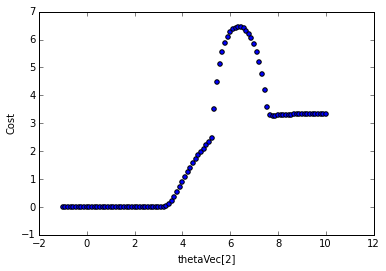

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import cost_xorRNN as cr
%matplotlib inline
thetaVec_f = np.linspace(-1.0, 10.0, 100)
thetaVec_all = np.array([ -18.37619967,  124.9886293 ,    0.69066491,   -2.38403005,
         -2.3863598 ,   34.07749817,   -4.0086386 ,  -99.19477153,
          5.28132817,  154.89424477,   17.32554579,  -64.2570698 ,
         16.34582581,  -20.79296525,  -21.30831168,  -15.76185224,
          4.64747081,  -65.70656672,   13.59414862,  -53.70279419,
        113.13004224,  -33.56398667,    0.7257491 ,   -9.27982256,
        -18.29977063,  129.48720956,  -37.57674034,  -30.04523486,
        -90.35656788])
thetaVec_sample = [np.concatenate((thetaVec_all[0:2], np.array([theta_]), thetaVec_all[3:]), axis=0) 
                   for theta_ in np.nditer(thetaVec_f)]
Xs = np.matrix('[0;0;1;1;0]')
Ys = np.matrix('[0;0;1;0;1]')
zs = np.array([cr.costRNN(np.array(theta_s).T, *(Xs, Ys))[0] for theta_s in thetaVec_sample]).flatten()
ax = plt.subplot(111)
#ax.set_yscale('log') #Try uncommenting this to see a different perspective
ax.set_ylabel('Cost')
ax.set_xlabel('thetaVec[2]')
plt.scatter(thetaVec_f, zs)
plt.show()

<p>You don't really need to understand the code behind this graph. Essentially what I'm doing is taking the set of optimal weights returned from the optimization function, and then changing the third weight (arbitrarily chosen) in the unrolled weight vector to between the values of -1 to -10 and calculating the cost for each new set of weights (but of the 29 total weights, only one individual weight is changed). So we're only looking at the cost as a function of <b>1</b> individual weight. The graph looks different if you look at a different weight, but the point is, this is not a nice cost surface. If our initial weight lands somewhere left of 6, then we'll probably be able to gradient descent down to the minimum, but if it lands to the right, we'll probably get stuck in that local minimum. Now imagine all 29 weights in our network having a cost surface like this and you can see how it gets ugly. <b>The take-away here is that RNNs have a lot of local optima that make it really difficult to train with the typical methods we use in feedforward networks.</b> Ideally, we want a cost function that is smooth and convex.
</p>

### Let's build a mini, mini, mini char-RNN

What's "mini, mini, mini char-RNN" ? If you're familiar with Karpathy's charRNN (http://karpathy.github.io/2015/05/21/rnn-effectiveness/) then you'll have an idea. We're going to build the simple RNN that predicts the next character in a short word like "hello" as presented on his blog. We're just going to modify the RNN we built above with a few key changes:

1) There is no longer a distinct Y vector of expected values. Our expected values are the next character in the sequence. So if we feed our RNN 'hell' we expect it to return 'ello' to complete the word we trained it on. So $y = X[j+1, :]$.


2) Since we have only have 4 characters in our "vocabularly", we'll represent them as binary vectors of length 4. I.e. our binary encoding (arbitrarily assigned) is: `h = [0 0 1 0], e = [0 1 0 0], l = [0 0 0 1], o = [1 0 0 0]`


3) We're going to expand the hidden layer from 4 to 10. Seems to make training faster.


4) Thus the input layer will now contain: 4 inputs + 10 context units + 1 bias = 11 total. And the output will contain  4 units since each letter is a vector of length 4.

As before, I'll reproduce the code below (two separate files: RNNoptim.py and cost_charRNN.py; but you could put it all in one file if you want) and explain the important points.

In [171]:
#cost_charRNN.py OUR COST FUNCTION FILE
import numpy as np
from sigmoid import sigmoid
def costRNN(thetaVec, *args):
	X = np.matrix(np.array(args))
	numIn, numHid, numOut = 4, 10, 4
	numInTot = numIn + numHid + 1
	theta1 = thetaVec[0:(numInTot * numHid)].reshape(numInTot, numHid)
	theta2 = thetaVec[(numInTot * numHid):].reshape(numHid+1, numOut)
	theta1_grad = np.zeros((numInTot, numHid))
	theta2_grad = np.zeros((numHid + 1, numOut))
	hid_last = np.zeros((numHid, 1))
	m = X.shape[0]
	J = 0
	results = np.zeros((m, numOut))
	for j in range(m-1): #for every training element
		#y = X[j+1,:] #expected output, the next element in the sequence
		y = X[j+1, :]
		context = hid_last
		x_context = np.concatenate((X[j, :], context.T), axis=1)
		a1 = np.matrix(np.concatenate((x_context, np.matrix('[1]')), axis=1)).T#add bias, context units to input layer; 3x1
		z2 = theta1.T * a1; #2x1
		a2 = np.concatenate((sigmoid(z2), np.matrix('[1]'))) #add bias, output hidden layer; 3x1
		hid_last = a2[0:-1, 0];
		z3 = theta2.T * a2 #1x1
		a3 = sigmoid(z3)
		results[j, :] = a3.reshape(numOut,)
		#Backpropagation:::
		#calculate delta errors
		d3 = (a3.T - y)
		d2 = np.multiply((theta2 * d3.T), np.multiply(a2, (1 - a2)))
		#accumulate gradients
		theta1_grad = theta1_grad + (d2[0:numHid, :] * a1.T).T
		theta2_grad = theta2_grad + (a2 * d3)
	for n in range(m-1):
		a3n = results[n, :].T.reshape(numOut, 1)
		yn = X[n+1, :].T
		J = J + (-yn.T * np.log(a3n) - (1-yn).T * np.log(1-a3n))
	J = (1/m) * J
	grad = np.concatenate((theta1_grad.flatten(), theta2_grad.flatten()), axis=1)
	return J, grad

That's our cost function file. It accepts an unrolled theta vector and the input data and returns the cost and the gradients. It is virtually the same as before besides the changed layer architecture and the fact that our $y$ (expected output) is just $X[j+1]$

In [174]:
import numpy as np
from sigmoid import sigmoid
from scipy import optimize
#Vocabulary h,e,l,o
#Encoding:   h = [0,0,1,0], e = [0,1,0,0], l = [0,0,0,1], o = [1,0,0,0]
X = np.matrix('0,0,1,0; 0,1,0,0; 0,0,0,1; 0,0,0,1; 1,0,0,0')
numIn, numHid, numOut = 4, 10, 4
numInTot = numIn + numHid + 1
theta1 = np.matrix( 1 * np.sqrt ( 6 / ( numIn + numHid) ) * np.random.randn( numIn + numHid + 1, numHid ) )
theta2 = np.matrix( 1 * np.sqrt ( 6 / ( numHid + numOut ) ) * np.random.randn( numHid + 1, numOut ) )
thetaVec = np.concatenate((theta1.flatten(), theta2.flatten()), axis=1)
opt = optimize.fmin_tnc(costRNN, thetaVec, args=(X), maxfun=5000)
optTheta = np.array(opt[0])
theta1 = optTheta[0:(numInTot * numHid)].reshape(numInTot, numHid)
theta2 = optTheta[(numInTot * numHid):].reshape(numHid+1, numOut)

def runForward(X, theta1, theta2):
	m = X.shape[0]
	#forward propagation
	hid_last = np.zeros((numHid, 1)) #context units
	results = np.zeros((m, numOut))
	for j in range(m):#for every input element
		context = hid_last
		x_context = np.concatenate((X[j,:], context.T), axis=1)
		a1 = np.matrix(np.concatenate((x_context, np.matrix('[1]')), axis=1)).T#add bias, context units to input layer
		z2 = theta1.T * a1 
		a2 = np.concatenate((sigmoid(z2), np.matrix('[1]'))) #add bias, output hidden layer
		hid_last = a2[0:-1, 0] #ignore bias
		z3 = theta2.T * a2
		a3 = sigmoid(z3)
		results[j, :] = a3.reshape(numOut,)
	return results
#This spells 'hell' and we expect it to return 'ello' as it predicts the next character for each input
Xt = np.matrix('0,0,1,0; 0,1,0,0; 0,0,0,1; 0,0,0,1')
print(np.round(runForward(Xt, theta1, theta2)))

[[ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


<b>That's cool.</b> Do you remember our encoding? h = [0,0,1,0], e = [0,1,0,0], l = [0,0,0,1], o = [1,0,0,0]
<br />
So we gave it 'hell' and it returned 'ello' ! That means, when it received the first character, [0,0,1,0] ("h"), it returned [ 0.  1.  0.  0.] ("e"). It knew what letter is supposed to come next! Neat.
<p>
Again, this is virtually identical to the network we built for XOR just that our input layer accepts binary 4 element vectors and returns 4 element vectors representing characters. We also increased the hidden layer size to 10.
</p>

####Closing Words

<p>If you want to take this farther, try increasing the number of characters you can encode by increasing the input and output layers. I tried (not shown here) up to 11 element vectors, using the letters "e t a o i n s h r d" (which are the top 10 highest frequency letters in english) and the space character. With just those 11 characters you can encode alot of words, even sentences. While I got it to work on individual words, training became increasingly difficult for longer input sequences (I tried expanding the hidden layer). My guess is that it just doesn't have enough 'memory' to remember more than a couple of characters back, therefore it won't be able to learn the character sequences of a long word or sentence. Hence why anyone doing 'real' character prediction (like the Karpathy charRNN) uses a much more sophisticated RNN, an LSTM network.</p>
<p>
I also attempted to build a character generator from this code, so that we train it on a word or small sentence and then tell it to generate some sequence of characters based on a seed/starting character or word. That didn't work well enough to present here, but if I get it working, I'll make a new post.
</p>
<p>Do note that I wrote this code for readability, thus it doesn't follow best coding practices like DRY.</p>
<p>Also, like I mentioned before, I had to resort to using a scipy optimizer to help train the network rather than use my own implementation of gradient descent like I did with the normal feedforward XOR network in my previous post. I suppose I was experiencing the exploding/vanishing gradient problem and I just didn't have a sophisticated enough gradient descent implementation. If you have any expertise to lend here then please email me (outlacedev@gmail.com). And please email me if you spot any errors.</p>

###References:

1. https://www.youtube.com/watch?v=e2sGq_vI41s (Elman Network Tutorial)
2. http://karpathy.github.io/2015/05/21/rnn-effectiveness/